<img src="files/QHack_poster.png" >

<img src="files/MA_RGB_Blue.jpg" width="200">

<font color=blue>
    
# The path to Quantum in production in the Financial Industry 
# The use case of Quantum Monte Carlo Simulation 

</font>

## Learning objectives of the challenge

**MAIN LEARNING OBJECTIVES**
1. Mapping a real problem to a quantum circuit. 
2. Programming quantum circuits. 
3. Optimizing quantum algorithms. 

**ABOUT THE INDUSTRY**

<div class="alert alert-block alert-success">
    
- What are the companies with potential use cases of quantum computing doing right now to prepare? 
    
- Why do financial institutions need to invest in Quantum Computing?
    
- What innovation framework do companies use to decide what emerging technology should be investigated?
    
</div>



**ABOUT THE PROBLEMS. SIZE. CLASSICAL METHODS. AND ~QUANTUM~ BUSINESS ADVANTAGE**
<div class="alert alert-block alert-success">

* What is the size of the problems real companies need to solve in production and when does quantum become relevant?

* What state of the art methods would quantum have to compete with?

* What benchmarks should we do to decide if we substitute a classical method with a quantum one?

* Should we talk about quantum advantage or business advantage?
    
</div>

**ABOUT INTEGRATION AND "QuantumOps"**

<div class="alert alert-block alert-success">

* What tools/ libraries need to be used in order to integrate quantum with other accelerators such as GPUs/ CPUs/ FPGAs etc?

* How do you orchestrate all the resources needed to solve a production size problem?

* How to manage the life cycle of a model in production?

* How do we integrate a quantum computer, with the current infrastructure a company has?

* How do we integrate a quantum solver with the current software products a company has?

* What are all the layers that we have to take into consideration when using a quantum computer in production? </div>

## The challenge

### Problem Statement 

Let $S_t$ be a stochastic process indexed by time $t$. Let the dynamics of $S_t$ be given by:

**Eq. (1)** $$ dS_t = \mu S_t dt + \sigma S_t dW_t $$ 

where $S_0=50$, $\mu= 0.1$ and $\sigma= 0.2$ are constants, and $dW_{t}$ is change in a standard Gaussian process in $dt$ time and can be thought of as:

$$dW_t=\mathcal{N}(0,1)\sqrt{dt}$$


This kind of stochastic process is known as a geometric Brownian motion (GBM) (also known as exponential Brownian motion).


### SECTION 1: The classical solution. Monte Carlo Simulation.

Using the above write a simulation code to compute:

* $\mathbb{E}[S_T]$

where T=10

Some theory:

* The expectation of a random variable can be estimated by averaging samples (let $X \stackrel{}{\sim} p(x)$):
$$\mathbb{E}[X]= \int xp(x)dx \approx \frac{1}{N}\sum_{j=1}^{N}X_j $$

* When performed on a digital computer (classical or quantum), any continuous $p(x)$ must be truncated and discretised:
$$\mathbb{E}[X]= \sum_x xp(x) \approx \frac{1}{N}\sum_{j=1}^{N}X_j $$


<div class="alert alert-block alert-warning">
<b>Hints:</b> 
    
- Discretize the time between t=0 to t=T in 100 steps.
- Use **Eq. (1)** to generate 10000 paths between t=0 to t=T (discretize the differential equation.)
- Compute the expectation by averaging over the paths.
- Another option is to use the analytical solution of the SDE, which is possible for this Stochastical Differential equation.
    
</div>


This problem is usually solved using Monte Carlo simulation. Monte Carlo sampling is a set of techniques that randomly generate numerical quantities for the purpose of simulating a statistical distribution or computing a moment or other expectation thereof (e.g., mean, variance).

Expect to see an exponential growth of $\mathbb{E}[S_t]$\
$S_t=S_0\ exp((\mu-\sigma^2/2)t+\sigma W_t)$

In [86]:
import numpy as np
import matplotlib.pyplot as plt
S0, mu, sigma = 50, 0.1, 0.2
T, m, M = 10, 100, 10000
dt = float(T) / m
K = 100
# M := number of paths
# m := T/dt

def exp_S_analytic():
    St = np.exp(
        (mu - sigma ** 2 / 2) * dt
        + sigma * np.random.normal(0, np.sqrt(dt), size=(M,m)).T
    )

    St = np.vstack([np.ones(M), St])

    St = S0 * St.cumprod(axis=0) # cumulative product
    return St

def exp_S():
    S = np.zeros((m+1,M))
    S[0] = S0
    for i in range(m):
        dS = mu * S[i,:] * dt + sigma * S[i,:] * np.random.normal(0, np.sqrt(dt), size=(M))
        S[i+1,:] = S[i,:] + dS
    return S

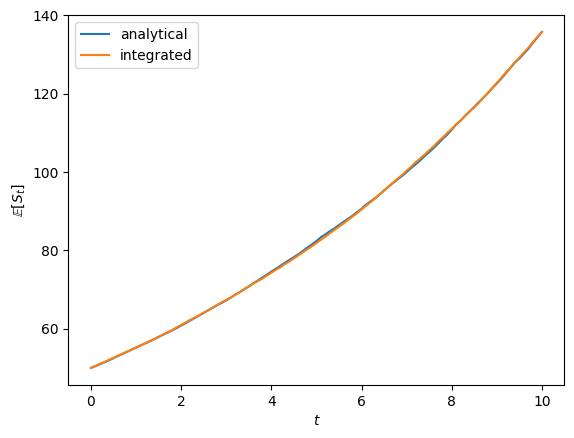

In [87]:
time = np.linspace(0,T,m+1)

analytic_ans = exp_S_analytic()
ans = exp_S()

# Require numpy array that is the same shape as St
plt.plot(time, analytic_ans.mean(axis=1), label="analytical")
plt.plot(time, ans.mean(axis=1), label="integrated")
plt.xlabel("$t$")
plt.ylabel("$\mathbb{E}[S_t]$")
plt.legend(loc="upper left")
plt.show()

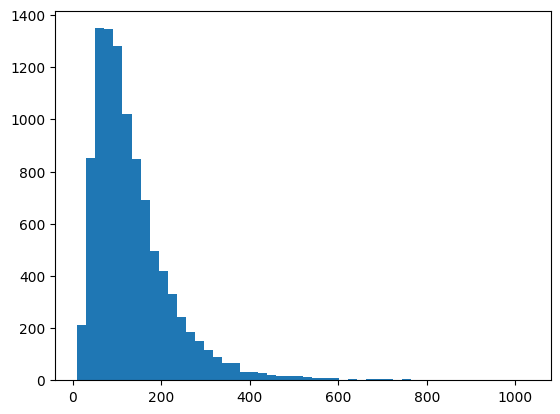

In [88]:
# empirical distribution of S_T at T=10
counts, bins = np.histogram(ans[-1,:], bins=50)
_ = plt.hist(bins[:-1], bins, weights=counts)

# Expectation estimated using classical MC is around 49~50

In [89]:
print(ans[-1,:].mean())                                           # E[S_T]
print(np.maximum(ans[-1,:] - K, np.zeros_like(ans[-1,:])).mean()) # E[max(S_T - K, 0)]

135.73610264923073
50.01423183850175


### SECTION 2: The Quantum solution. Quantum Monte Carlo Integration + QAE
Now you are required to derive:
* $\mathbb{E}[max(S_T-100, 0)]$ 

with a quantum computer using the Quantum Amplitude Estimation Algorithm.

Some more theory:

* We may want to estimate the expectation when a function is applied to the samples:

$$\mathbb{E}[f(X)]= \sum_x f(x)p(x) \approx \frac{1}{N}\sum_{j=1}^{N}f(X_j) $$


* Monte-Carlo Integration is a three step process:

<div class="alert alert-block alert-info">
Prepare samples -> Apply a function -> average
</div>


* and Quantum Monte-Carlo Integration is essentially the same:

<div class="alert alert-block alert-info">
Prepare a state -> Apply circuit encoding the function -> QAE algorithm
</div>


#### BACKGROUND OF THE ALGORITHM

Quantum Amplitude Estimation (QAE) __[[1]](https://arxiv.org/abs/quant-ph/0005055)__  is a fundamental quantum algorithm with the potential to achieve a quadratic speedup for many applications that are classically solved through Monte Carlo (MC) simulation. 

This algorithm could provide an advantage in some relevant applications in the financial sector. In fact, it has been shown how to apply QAE to the problems of option pricing __[[2]](https://arxiv.org/abs/1905.02666)__, risk analysis __[[3]](https://www.nature.com/articles/s41534-019-0130-6)__, __[[4]](https://arxiv.org/abs/2212.07125)__, __[[5]](https://www.mdpi.com/1099-4300/25/4/593)__ and also for generical tasks such as numerical integration __[[6]](https://arxiv.org/abs/1504.06987)__, among others.

<div class="alert alert-block alert-info">
While the estimation error bound of classical MC simulation scales as O(1/√M), where M denotes the number of (classical) samples, QAE achieves a scaling of O(1/M) for M (quantum) samples, indicating the aforementioned quadratic speedup.

</div>


QAE was first proposed in 2000 by Brassard and others. However, the first version of the algorithm, that is, the canonical version, requires a very high number of qubits and circuit depth, which makes it impractical in today’s NISQ devices. QAE combines Quantum Phase Estimation (QPE) and Grover’s Algorithm.  Later studies have focused on how to optimize the QAE algorithm. The strategy has been to remove the QPE-dependency and use only Grover iterations. It has been empirically observed that including QPE in QAE does not have any advantages, it only increases the complexity. Moreover, the removal of the QPE-dependency has resulted in reducing the resource requirements of QAE, bringing closer the possibility of practical applications of QAE in the near-term.


There are 3 main pain points to work on when solving a problem with this algorithm:
1. Uploading the initial probability distribution.
2. Computation = iterations of the algorithm (circuit depth).
3. Measuring and Post processing.

Each  of the parts have their own challenge, and in order to maintain the theoretical quadratic speedup, we have to efficiently solve each of the steps.

There are different versions of QAE:

* Canonical QAE __[[1]](https://arxiv.org/abs/quant-ph/0005055)__
* Maximum Likelihood Amplitude Estimation MLAE __[[2]](https://arxiv.org/abs/1904.10246)__
* QAE Simplified QAES __[[3]](https://arxiv.org/abs/1908.10846)__
* Iterative QAE IQAE __[[4]](https://arxiv.org/abs/1912.05559)__
* Variational QAE __[[5]](https://arxiv.org/abs/2109.03687)__

and more.

In order to do Quantum Monte-Carlo Integration one may choose among the different versions of QAE.

In a recent paper, Steven Herbert proposes a method to do Quantum-monte Carlo Integration called Fourier QMCI __[[6]](https://arxiv.org/abs/2105.09100)__ that provides an optimal way to do the step of encoding the function into a circuit.

For more information on Quantum proposals to enhance Monte Carlo methods, read __[A Survey of Quantum Alternatives to Randomized Algorithms: Monte Carlo Integration and Beyond](https://arxiv.org/abs/2303.04945)__

You are required to work on the 3 steps mentioned above, and hand in the outputs defined below.

# Expected Outputs

## 1. Data uploading step. 
* Explore different techniques to efficiently upload the stochastic process. Choose and implement the technique you want and justify why. For simulation experiments, you may choose the number of samples in the probability distribution you want to consider, we recommend to start with 4. 

<font color=red>
Optional. Advanced exercise. (We recommend to try this after solving the rest of the challenge). Try to encode a Cox-Ingersoll-Ross process into a quantum computer. What about a Heston model?</font> 


<div class="alert alert-block alert-warning">
<b>Hints:</b> 
    
- Read __[The Problem with Grover-Rudolph State Preparation for Quantum Monte-Carlo](https://arxiv.org/abs/2101.02240)__ to understand why efficiently doing this step is important.
    
- __[qGAN](https://www.nature.com/articles/s41534-019-0223-2)__ have been proposed as an alternative promising way of efficiently uploading data.
    
- Read about stochastic processes uploading in __[Quantum-enhanced analysis of discrete stochastic processes](https://www.nature.com/articles/s41534-021-00459-2)__
    
</div>

[Pricing European Call Options](https://qiskit.org/ecosystem/finance/tutorials/03_european_call_option_pricing.html) \
[Quantum Amplitude Estimation](https://qiskit.org/ecosystem/finance/tutorials/00_amplitude_estimation.html) \
[Option Pricing with qGANs](https://qiskit.org/ecosystem/finance/tutorials/10_qgan_option_pricing.html)

In [90]:
# Data Uploading Step
from qiskit import QuantumCircuit
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import LogNormalDistribution

num_uncertainty_qubits = 6

mu_      = (mu - 0.5 * sigma**2) * T + np.log(S0)
sigma_   = sigma * np.sqrt(T)
mean     = np.exp(mu_ + sigma_**2 / 2)
assert abs(mean - S0 * np.exp(mu * T)) < 1
variance = (np.exp(sigma_**2) - 1) * np.exp(2 * mu_ + sigma_**2)
stddev = np.sqrt(variance)
print(mean, stddev)
                 

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 5 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu_, sigma=sigma_**2, bounds=(low, high)
)

135.9140914229523 95.31684375952338


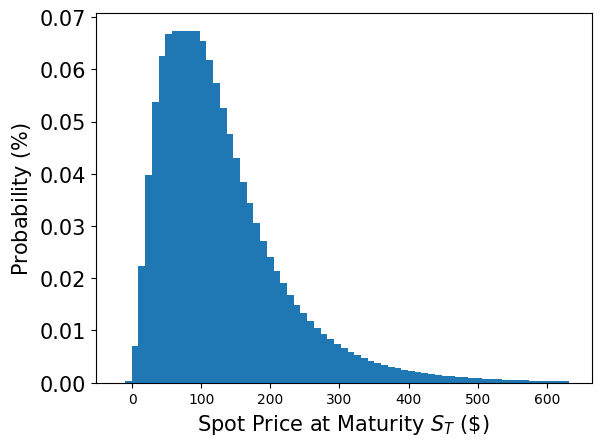

<Figure size 10000x8000 with 0 Axes>

In [91]:
# plot probability distribution
dis_x = uncertainty_model.values        # discretized x
dis_y = uncertainty_model.probabilities # p(x) at these values
# print(dis_x, dis_y)
plt.bar(dis_x, dis_y, width=40)
# plt.xticks(dis_x, size=15, rotation=90)
plt.yticks(size=15)
# plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.figure(figsize=(100,80))
plt.show()

$\newcommand{\ra}{\rangle}$
$\newcommand{\vect}[1]{{\mathbf{\boldsymbol{{#1}}}}}$
QMCI can be achieved by constructing a matrix $A=R(P\otimes I)$ where\
$$P|0\ra =|p\ra = \sum_{\vect{x}\in\{0,1\}^N} \sqrt{p(\vect{x})}|\vect{x}\rangle$$
$$R = |\vect{x}\ra |0\ra = |\vect{x}\ra (\sqrt{1-f(\vect{x})} |0\ra + \sqrt{f(\vect{x})} |1\ra)$$

<!-- Temporarily set $K=1$.\ -->
Benchmark against the IBM $sin^2(x+\pi/4)\approx x+1/2$ method (Linear Amplitude Estimation).


## 2. QAE. 
* You are asked to implement Fourier QMCI __[[6]](https://arxiv.org/abs/2105.09100)__ and apply it to the function described in the problem statement $max(S_T-100, 0)$
* What benefits does it have vs the other versions? 


<div class="alert alert-block alert-warning">
<b>Hints:</b> 
    
- You do not need to derive the circuits of each version of QAE from scratch. Qiskit has some of the versions of QAE implemented as classes. You can explore the circuits using these classes. Check them out __[here](https://qiskit.org/documentation/apidoc/algorithms.html)__.
- Qiskit can also help deriving the __[circuit depth](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.depth.html)__.
- Note that Fourier QMCI can make use of any of the versions of QAE.
    
</div>

### QSAM measurements match the empirical mean $\mathbb{E}[f(X)]\approx \sum_{i\in\{0,1\}^N} p(X_i)\cdot f(X_i)$ calculated classically!

In [92]:
from qiskit.circuit.library import RYGate, CRYGate
from qiskit import *
from qiskit.providers.aer import QasmSimulator

print(low, high)
T = high - low
N = num_uncertainty_qubits
omega = 2 * np.pi / T
Delta = T / (2**N - 1)
num_shots = 10**5

def exp_of_tri(n, beta=0): # compute the expectation of cos(nwx) or sin(nwx), w is Omega
    # n in the index in the Fourier Serier
    # beta=0 for cosine, beta = pi/2 for sine
    alpha = n * omega * low - beta 
    theta = n * omega * Delta
    tri_circ = QuantumCircuit(QuantumRegister(num_uncertainty_qubits + 1), ClassicalRegister(1))
    tri_circ.append(uncertainty_model, range(num_uncertainty_qubits))
    tri_circ.append(RYGate(alpha), [N])
#     for i in range(1, N+1):
#         tri_circ.append(CRYGate(theta * (2**i)), [N-i,N]) # Prob encoding was in the reversed order!
    for i in range(0, N):
        tri_circ.append(CRYGate(theta * (2**i)), [i, N])
    tri_circ.measure(N, 0)
    
    backend = Aer.get_backend("qasm_simulator")
    job = execute(tri_circ, backend, shots=num_shots)
    result = job.result()
    counts = result.get_counts()
#     print(counts)
    if '1' not in counts.keys():
        counts['1'] = 0
#     tri_circ.draw()
    return 1 - 2 * float(counts['1']) / num_shots    # the probabiliy of state |1>

exp_cos = exp_of_tri(5, np.pi/2)
print(exp_cos)

def exp_of_cos_classical(n):
    cosx = [np.cos(n * omega * x) for x in dis_x]
    return (cosx * dis_y).sum()

def exp_of_sin_classical(n):
    sinx = [np.sin(n * omega * x) for x in dis_x]
    return (sinx * dis_y).sum()

print(exp_of_sin_classical(5))

0.0 612.4983102205692
-0.0505199999999999
-0.04957578032644529


Showing the circuit for calculating $\mathbb{E}[\cos(n\omega x)]$ of a single $n$.

In [93]:
n, beta = 1, 0
alpha = n * omega * low - beta 
theta = n * omega * Delta
tri_circ = QuantumCircuit(QuantumRegister(num_uncertainty_qubits, 'qb'), QuantumRegister(1, 'a'), ClassicalRegister(1))
tri_circ.append(uncertainty_model, range(num_uncertainty_qubits))
tri_circ.append(RYGate(alpha), [N])
for i in range(0, N):
    tri_circ.append(CRYGate(theta * (2**i)), [i,N])
tri_circ.measure(N, 0)
tri_circ.draw()

┌───────┐                                                             »
 qb_0: ┤0      ├───────■─────────────────────────────────────────────────────»
       │       │       │                                                     »
 qb_1: ┤1      ├───────┼───────────────■─────────────────────────────────────»
       │       │       │               │                                     »
 qb_2: ┤2      ├───────┼───────────────┼──────────────■──────────────────────»
       │  P(X) │       │               │              │                      »
 qb_3: ┤3      ├───────┼───────────────┼──────────────┼──────────────■───────»
       │       │       │               │              │              │       »
 qb_4: ┤4      ├───────┼───────────────┼──────────────┼──────────────┼───────»
       │       │       │               │              │              │       »
 qb_5: ┤5      ├───────┼───────────────┼──────────────┼──────────────┼───────»
       ├───────┤┌──────┴───────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐»
    a: ┤ Ry(0) ├┤ Ry(0.099733) ├┤ Ry(0.19947) ├┤ Ry(0.39893) ├┤ Ry(0.79786) ├»
       └───────┘└──────────────┘└─────────────┘└─────────────┘└─────────────┘»
c15: 1/══════════════════════════════════════════════════════════════════════»
                                                                             »
«                                      
« qb_0: ───────────────────────────────
«                                      
« qb_1: ───────────────────────────────
«                                      
« qb_2: ───────────────────────────────
«                                      
« qb_3: ───────────────────────────────
«                                      
« qb_4: ──────■────────────────────────
«             │                        
« qb_5: ──────┼─────────────■──────────
«       ┌─────┴──────┐┌─────┴──────┐┌─┐
«    a: ┤ Ry(1.5957) ├┤ Ry(3.1915) ├┤M├
«       └────────────┘└────────────┘└╥┘
«c15: 1/═════════════════════════════╩═
«                                    0

# Quantum MC (simulated by QSAM) match the classical MC results quite well!

Step 1: Extract Fourier coefficients and showcase that they indeed approximate $\text{f}(x)$ better and better with larger $n_{max}$.

In [94]:
from scipy.integrate import quad

def f(x):
    if isinstance(x, float):
        assert low <= x
        assert x <= high
        if x == high:
            x = low
        return max(0, x - K)
    elif isinstance(x, np.ndarray):
        assert np.all(low <= x)
        assert np.all(x <= high)
        x[x==high] = low
        return np.clip(a=x-K, a_min=0, a_max=None)
    else:
        raise ValueError('x should be float or np.ndarray!')
  
def f_periodic(x):
    x_shifted = (x - low) % T + low
    return f(x_shifted)
    
def create_coef(n_max):
    c = 1.0 / T * quad(func=f, a=low, b=high)[0]
    a = np.zeros(n_max, dtype=float)
    b = np.zeros(n_max, dtype=float)
    pre_factor = 2.0 / T
    for n in range(n_max):
        nw = (n+1) * omega
        a[n] = quad(
            func=f, a=low, b=high, weight='cos', wvar=nw
        )[0] * pre_factor
        b[n] = quad(
            func=f, a=low, b=high, weight='sin', wvar=nw
        )[0] * pre_factor
    return a, b, c

def f_series(x, a, b, c, n_max):
    if isinstance(x, float):
        ans = c
    elif isinstance(x, np.ndarray):
        ans = c * np.ones_like(x, dtype=float)
    else:
        raise ValueError('x should be float or np.ndarray!')
    for n in range(n_max):
        nw = (n+1) * omega
        ans += a[n] * np.cos(nw*x)
        ans += b[n] * np.sin(nw*x)
    return ans


nmax=1.000000e+00, rerr=4.599929e-01 c=214.41
nmax=1.000000e+01, rerr=4.087765e-01 c=214.41
nmax=1.000000e+02, rerr=2.900358e-01 c=214.41
nmax=1.000000e+03, rerr=8.102824e-03 c=214.41
nmax=1.000000e+04, rerr=2.775070e-03 c=214.41


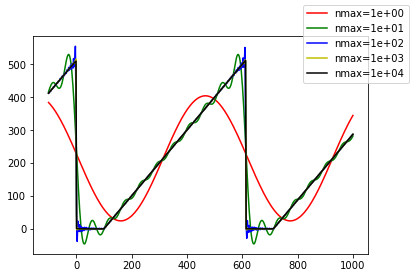

In [22]:
NMAX = (1, 10, 100, 1000, 10000)
x = np.linspace(-100, 1000, num=500)
colors = ('r', 'g', 'b', 'y', 'k')

fig, ax = plt.subplots()
y_ref = f_periodic(x)
ax.plot(x, y_ref)
for (i, nm) in enumerate(NMAX):
    a,b,c = create_coef(nm)
    y_this = f_series(x, a, b, c, nm)
    rerr = np.max(np.abs(y_ref-y_this))/high
    print('nmax={0:e}, rerr={1:e} c={2:.2f}'.format(nm, rerr, c))
    ax.plot(
#         x, y_this, color=colors[i], label='nmax={0:.0e}, rerr={1:.2e}'.format(nm,rerr)
        x, y_this, color=colors[i], label='nmax={0:.0e}'.format(nm,rerr)
    )
fig.legend()

Step 2: Run QASM simulation of each circuit in order to obtain $\mathbb{E}[\cos(n\omega x)]$ or $\mathbb{E}[\sin(n\omega x)]$. Multiply the result with the corresponding Fourier coefficients, then sum these products up.

In [27]:
n_max = 10
a, b, c = create_coef(n_max)
# calculating the expectation of max(S_T-K, 0)
cos_exps = [exp_of_tri(n+1, beta=0) for n in range(n_max)]
sin_exps = [exp_of_tri(n+1, beta=np.pi/2) for n in range(n_max)]
print(c + (a * cos_exps).sum() + (b * sin_exps).sum())

47.303118057426616


### Conclusion: The QASM simulation of our circuit (and the post-processing) does give a close result (47\~48) to the classical calculation of $\mathbb{E}[f(X)]\approx \sum_{i\in\{0,1\}^N} p(X_i)\cdot f(X_i)$. They are both quite close to the estimated value of the sample-based classical MC (49\~50).

In [26]:
cos_exps_exact = [exp_of_cos_classical(n+1) for n in range(n_max)]
sin_exps_exact = [exp_of_sin_classical(n+1) for n in range(n_max)]
print(c + (a * cos_exps_exact).sum() + (b * sin_exps_exact).sum())

47.92776630143416


## 3. Execution
* Let's think about parallelization: What versions of QAE can be parallelized? At which level (iteration/shot)? When does it become relevant? What advantage does it bring compared to a sequential execution?
* Explain how you would parallelize the Fourier QMCI and the QAE you have chosen if that QAE version can be paralellized.
* Define a workload of tasks and orquestrate its execution. Include any assumptions you make (e.g. I have access to 20 Quantum Computers based in the same data center...).
* Compare the different approaches.


<div class="alert alert-block alert-warning">
<b>Hints:</b> 
    
- Read the steps of the algorithm and think whether iterations depend on the previous one or the can be done simultaneously in different quantum backends. 
_ Think about how to parallelize Fourier QMCI.
- Think about the number of iterations, circuit depth, and the number of shots.
- Use __[covalent.xyz](https://www.covalent.xyz)__ to define a workflow of the things you need to execute.
- Check the opensource platform __[NVIDIA CUDA Quantum](https://developer.nvidia.com/cuda-quantum)__ and their view on orchestration of hybrid workflows. 
- __[Orquestra](https://www.orquestra.io)__ by Zapata Computing is not open source, but may also give you some ideas.
    
- <font color=red> (Optional. Avanced) Other proposals __[Error Resilient Quantum Amplitude Estimation from Parallel Quantum Phase Estimation](https://arxiv.org/abs/2204.01337)__ </font>
    
</div>

### Now we aim to parallize the classical calculation of Fourier coefficient $a_k$ with quantum evaluation of $\mathbb{E}[\cos{(k\omega x)}]$. The quantum evalution is left as a place-holder here because we need to queue before running on a quantum hardware.

Start a local server by typing
```covalent start```
in command line before running the code below. Go to localhost:48008 to see the produced work-flow graph.

In [28]:
import covalent as ct
n_max = 3 # produce a naive graph

@ct.electron
def add(x, y):
    return x + y

@ct.electron
def mul(x, y):
    return x * y

@ct.electron
def create_coef_n(n, type='a'):
    if n == 0:
        c = 1.0 / T * quad(func=f, a=low, b=high)[0]
        return c
    nw = n * omega
    pre_factor = 2.0 / T
    if type == 'a':
        return quad(func=f, a=low, b=high, weight='cos', wvar=nw
        )[0] * pre_factor
    elif type == 'b':
        return quad(func=f, a=low, b=high, weight='sin', wvar=nw
        )[0] * pre_factor

@ct.electron
def exp_of_tri_n(n, beta=0):
    return beta # place-holder

@ct.lattice
def run_QMCI_exp():
   
    c = create_coef_n(0)
    
    a1 = create_coef_n(1, 'a')
    exp_cos1 = exp_of_tri_n(1, beta=0)
    s = mul(a1, exp_cos1)
    exp = add(s, c)
    
    a2 = create_coef_n(2, 'a')
    exp_cos2 = exp_of_tri_n(2, beta=0)
    s = mul(a2, exp_cos2)
    exp = add(s, exp)
    
    a3 = create_coef_n(3, 'a')
    exp_cos3 = exp_of_tri_n(3, beta=0)
    s = mul(a3, exp_cos3)
    exp = add(s, exp)
    
    b1 = create_coef_n(1, 'b')
    exp_sin1 = exp_of_tri_n(1, beta=np.pi/2)
    s = mul(b1, exp_sin1)
    exp = add(s, exp)

    b2 = create_coef_n(2, 'b')
    exp_sin2 = exp_of_tri_n(2, beta=np.pi/2)
    s = mul(b2, exp_sin2)
    exp = add(s, exp)
    
    b3 = create_coef_n(3, 'b')
    exp_sin3 = exp_of_tri_n(3, beta=np.pi/2)
    s = mul(b3, exp_sin3)
    exp = add(s, exp)   
    
    return exp

    
dispatch_id = ct.dispatch(run_QMCI_exp)()


## Shots reduction by adding Ancillas

By symmetry, each ancilla is experiencing the same action, so the statistics are the same. Hence, when we add the counts we can actually multiplex the results. We set a rotation on qubit 0 and we let there be two identical Controlled rotations, acting on different qubits. Then as can be seen below, the problem is symmetric. Therefore, when for a single n when we run a 1000 shots on a single ancilla this can be transformed into 1000 / number_of_ancillas shots, yielding the same results. Since before the measurement, all gates commute, because no two CRY gates has a control equal to the target of another. 

Below is a representation for a rotation of $5\pi/8$.

In [25]:
qr = QuantumRegister(3, 'qb')
cr = ClassicalRegister(2)
cirq = QuantumCircuit(qr, cr)

cirq.ry(np.pi/4, 0)
cirq.append(CRYGate(5*np.pi/8), [0, 1])
cirq.append(CRYGate(5*np.pi/8), [0, 2])
cirq.measure([1, 2], [0, 1])

cirq.draw()

┌─────────┐                              
qb_0: ┤ Ry(π/4) ├─────■───────────■────────────
      └─────────┘┌────┴─────┐     │      ┌─┐   
qb_1: ───────────┤ Ry(5π/8) ├─────┼──────┤M├───
                 └──────────┘┌────┴─────┐└╥┘┌─┐
qb_2: ───────────────────────┤ Ry(5π/8) ├─╫─┤M├
                             └──────────┘ ║ └╥┘
c2: 2/════════════════════════════════════╩══╩═
                                          0  1

In [26]:
qr = QuantumRegister(2, 'qb')
cr = ClassicalRegister(1)
single_cirq = QuantumCircuit(qr, cr)
single_cirq.ry(np.pi/4, 0)
single_cirq.append(CRYGate(5*np.pi/8), [0, 1])
single_cirq.measure(1, 0)
single_cirq.draw()

┌─────────┐               
qb_0: ┤ Ry(π/4) ├─────■─────────
      └─────────┘┌────┴─────┐┌─┐
qb_1: ───────────┤ Ry(5π/8) ├┤M├
                 └──────────┘└╥┘
c3: 1/════════════════════════╩═
                              0

In [159]:
n_shots = 10000
backend = Aer.get_backend("qasm_simulator")
job = execute(cirq, backend, shots=int(n_shots/2))
result = job.result()
counts = result.get_counts()

print(counts)

single_backend = Aer.get_backend("qasm_simulator")
single_job = execute(single_cirq, backend, shots=n_shots)
single_result = single_job.result()
single_counts = single_result.get_counts()

print(single_counts)

qubit_1 = (counts['11'] + counts['10'])/n_shots
qubit_2 = (counts['11'] + counts['01'])/n_shots

single_qubit = single_counts['1'] / n_shots

print(f'Result of two ancillas: {qubit_1 + qubit_2}')
print(f'Result of one ancilla: {single_qubit}')


{'00': 4337, '11': 338, '10': 170, '01': 155}
{'0': 8971, '1': 1029}
Result of two ancillas: 0.1001
Result of one ancilla: 0.1029


As can be seen from the random statistics, the results are pretty close as required.

### Multiple qubit realisation

Below is an implementation of the Fourier Monte Carlo Integration circuit, for a single Fourier index n. The number of qubits, i.e. the discretization can be chosen, as well as the ancilla qubits, i.e. the shots reduction. The algorithm permutes the gate entries such that they can be executed on different qubits at the same time. 

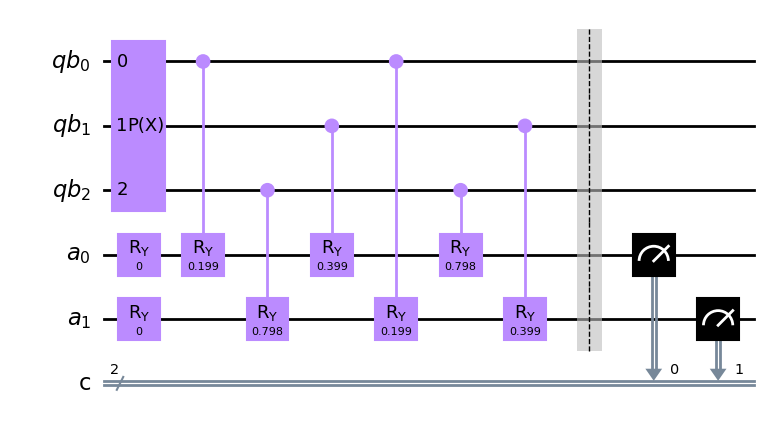

In [53]:
n = 2
num_qubits = 3
num_ancilla = 2

T = high - low
omega = 2 * np.pi / T
Delta = T / (2**N - 1)
alpha = n * omega * low - beta 
theta = n * omega * Delta

uncertainty_model = LogNormalDistribution(
    num_qubits, mu=mu_, sigma=sigma_**2, bounds=(low, high)
)

tri_circ = QuantumCircuit(QuantumRegister(num_qubits, 'qb'), QuantumRegister(num_ancilla, 'a'), 
                          ClassicalRegister(num_ancilla, 'c'))
tri_circ.append(uncertainty_model, range(num_qubits))

# Initial rotation. 
for i in range(0, num_ancilla): 
    tri_circ.append(RYGate(alpha), [num_qubits+i])


# num_ancilla permutations
angles_pairs = np.array([[theta * 2**i, i] for i in range(0, num_qubits)])
new_angles = np.zeros((angles_pairs.shape))

for i in range(0, num_ancilla):
    new_angles = np.dstack((new_angles, np.roll(angles_pairs, i, axis=0)))

new_angles = new_angles[:, :, 1:]

# for i in range(0, num_ancilla):
#     for i, (angle, qubit) in current_angles[i]:
# #         tri_circ.append(CRYGate(angle), [int(qubit), num_qubits+i])

angles_pairs = np.array([[theta * 2**i, i] for i in range(0, num_qubits)])
new_angles = np.zeros((angles_pairs.shape))

for i in range(0, num_ancilla):
    new_angles = np.dstack((new_angles, np.roll(angles_pairs, i, axis=0)))

new_angles = new_angles[:, :, 1:]
for i in range(0, num_ancilla+1):
    for j, group in enumerate(new_angles[i,:,:].T):
        tri_circ.append(CRYGate(group[0]), [int(group[1]), num_qubits+j])

tri_circ.barrier()
tri_circ.measure([num_qubits + i for i in range(0, num_ancilla)], [i for i in range(0, num_ancilla)])
tri_circ.draw('mpl', filename='C:\\Users\\hidde\\OneDrive\\ETH\\Spring 2022\\Quantum Hackathon\AncillaCircuit')

Extract the counts for the right label. 

In [163]:
import itertools
backend = Aer.get_backend("qasm_simulator")
shots = 10000
job = execute(tri_circ, backend, shots=shots)
result = job.result()
counts = result.get_counts()
states = ["0", "1"]
iterable = [states] * num_ancilla

count = 0
for i in range(0, num_ancilla):
    for state in itertools.product(*iterable):
        if state[i] == '1':
            state = ''.join(state)
            count += counts[state] / (num_ancilla * shots)

print(count)

0.64575


## Distributed discretized qubits 

Imagine in the future that the discretization will cover about a million nodes. It is not unimaginable that by that time we would not necessarily have a million qubit chip, but we do have multiple well functioning large chips. In this case the computing can be distributed to multiple chips. There are multiple scenarios:
- There is one ancilla, multiple banks of qubits storing the discretization.
- There are multiple banks of ancillas, one bank of qubits storing the discretization. 
- There are multiple banks fo ancillas and multiple banks of qubits.

In the first case the ancilla interacts with different nodes on the quantum network after one another. The second case is more optimal, a single bank can interact with multiple nodes as long as the control qubits and target qubits are different. In the third case we have a combination of the first and second situation. Here we would optimize to use as many ancillas and storage banks at the same time as possible. If the ancilla chips are large enough the previous algorithm can be implemented to optimize the performance even further. 

<font color=red>

## 4. Noise analysis step (Optional. Advanced.)

(We recommend to try this after solving the rest of the challenge).
    
* Can you execute QMC in NISQ devices?
* How would you execute it in a quantum backend?
* How did you compile the circuits? What is the circuit depth after transpilation?
* Did you use any noise mitigation technique? If yes, explain which one and how if affected the results.
    
</font>




<div class="alert alert-block alert-warning">
<b>Hints:</b> 

- You can use an open backend from IBM Quantum, or an Aer simulator.
    
- Check this paper about __[Noise-Aware QAE](https://arxiv.org/abs/2109.04840)__

- You can use __[Fire Opal](https://q-ctrl.com/fire-opal)__ to optimize your results. __[Documentation](https://docs.q-ctrl.com/fire-opal/user-guides/how-to-set-up-your-environment-and-install-fire-opal)__


    
</div>




In [72]:
# Write your code here
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit.circuit.library import RYGate, CRYGate
from qiskit import *
from qiskit.providers.aer import QasmSimulator
import fireopal

# Initialize the account first.
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="your_token")

In [73]:
service = QiskitRuntimeService()
service.backends(simulator=False, operational=True, min_num_qubits=5)

[<IBMBackend('ibmq_quito')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibmq_jakarta')>]

In [74]:
backend_name = 'ibmq_lima'
backend = service.backend(backend_name)

In [75]:
n = 2
T = high - low
N = num_uncertainty_qubits
omega = 2 * np.pi / T
Delta = T / (2**N - 1)
num_shots = 10**5
alpha = n * omega * low 
theta = n * omega * Delta
tri_circ = QuantumCircuit(QuantumRegister(num_uncertainty_qubits, 'qb'),
                          QuantumRegister(1, 'a'), 
                          ClassicalRegister(1))
tri_circ.append(uncertainty_model, range(num_uncertainty_qubits))
tri_circ.append(RYGate(alpha), [N])
for i in range(0, N):
    tri_circ.append(CRYGate(theta * (2**i)), [i,N])
tri_circ.measure(N, 0)
tri_circ.draw()

┌───────┐                                        
 qb_0: ┤0      ├─────■──────────────────────────────────
       │       │     │                                  
 qb_1: ┤1 P(X) ├─────┼───────────■──────────────────────
       │       │     │           │                      
 qb_2: ┤2      ├─────┼───────────┼────────────■─────────
       ├───────┤┌────┴─────┐┌────┴─────┐┌─────┴─────┐┌─┐
    a: ┤ Ry(0) ├┤ Ry(4π/7) ├┤ Ry(8π/7) ├┤ Ry(16π/7) ├┤M├
       └───────┘└──────────┘└──────────┘└───────────┘└╥┘
c13: 1/═══════════════════════════════════════════════╩═
                                                      0

In [23]:
sampler = Sampler(session=backend)
job = sampler.run(tri_circ, shots=2048)
result = job.result()
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: chbdfdhmfb1ddb51gtt0
>>> Job Status: JobStatus.DONE


In [24]:
print(result.quasi_dists[0][1])

0.5360701731018344


With this strategy we can essentially run the circuit on a real quantum computer. However, for the purposes of this task, that is not super usefull and will simply take a lot of time, since at the time of compiling this the QPU's were quite busy. 

In [29]:
transpile(tri_circ, backend=backend).draw()

global phase: 3π/2
                                                                        »
     qb_0 -> 0 ─────────────────────────────────────────────────────────»
               ┌────────┐┌────┐┌────────────┐┌────┐                     »
     qb_2 -> 1 ┤ Rz(-π) ├┤ √X ├┤ Rz(2.5556) ├┤ √X ├──■──────────────────»
               ├────────┤├────┤├────────────┤├────┤┌─┴─┐┌────────┐┌────┐»
     qb_1 -> 2 ┤ Rz(-π) ├┤ √X ├┤ Rz(1.9878) ├┤ √X ├┤ X ├┤ Rz(-π) ├┤ √X ├»
               ├────────┤├────┤└┬──────────┬┘├────┤└───┘└────────┘└────┘»
      a_0 -> 3 ┤ Rz(-π) ├┤ √X ├─┤ Rz(5π/7) ├─┤ √X ├─────────────────────»
               └────────┘└────┘ └──────────┘ └────┘                     »
ancilla_0 -> 4 ─────────────────────────────────────────────────────────»
                                                                        »
         c4: 1/═════════════════════════════════════════════════════════»
                                                                        »
«                                             ┌───┐                     »
«     qb_0 -> 0 ───────────────────────────■──┤ X ├──■──────────────────»
«                                        ┌─┴─┐└─┬─┘┌─┴─┐┌────────┐┌────┐»
«     qb_2 -> 1 ──────────────────────■──┤ X ├──■──┤ X ├┤ Rz(-π) ├┤ √X ├»
«               ┌────────────┐┌────┐┌─┴─┐└───┘     └───┘└────────┘└────┘»
«     qb_1 -> 2 ┤ Rz(2.8455) ├┤ √X ├┤ X ├───────────────────────────────»
«               └────────────┘└────┘└───┘                               »
«      a_0 -> 3 ────────────────────────────────────────────────────────»
«                                                                       »
«ancilla_0 -> 4 ────────────────────────────────────────────────────────»
«                                                                       »
«         c4: 1/════════════════════════════════════════════════════════»
«                                                                       »
«                                                                            »
«     qb_0 -> 0 ─────────────────────────────────────────────────────────────»
«               ┌────────────┐┌────┐┌───┐┌────────┐┌────┐┌────────────┐┌────┐»
«     qb_2 -> 1 ┤ Rz(1.4754) ├┤ √X ├┤ X ├┤ Rz(-π) ├┤ √X ├┤ Rz(2.6534) ├┤ √X ├»
«               └────────────┘└────┘└─┬─┘└────────┘└────┘└────────────┘└────┘»
«     qb_1 -> 2 ──────────────────────■──────────────────────────────────────»
«                                                                            »
«      a_0 -> 3 ─────────────────────────────────────────────────────────────»
«                                                                            »
«ancilla_0 -> 4 ─────────────────────────────────────────────────────────────»
«                                                                            »
«         c4: 1/═════════════════════════════════════════════════════════════»
«                                                                            »
«                                                                            »
«     qb_0 -> 0 ──■──────────────────────────────────────────────────────────»
«               ┌─┴─┐┌────────┐┌────┐┌───────────┐┌────┐┌───┐┌────────┐┌────┐»
«     qb_2 -> 1 ┤ X ├┤ Rz(-π) ├┤ √X ├┤ Rz(2.627) ├┤ √X ├┤ X ├┤ Rz(-π) ├┤ √X ├»
«               └───┘└────────┘└────┘└───────────┘└────┘└─┬─┘└────────┘└────┘»
«     qb_1 -> 2 ──────────────────────────────────────────■──────────────────»
«                                                                            »
«      a_0 -> 3 ─────────────────────────────────────────────────────────────»
«                                                                            »
«ancilla_0 -> 4 ─────────────────────────────────────────────────────────────»
«                                                                            »
«         c4: 1/═════════════════════════════════════════════════════════════»
«                                                                            »
«  

In [33]:
transpile(tri_circ, backend=backend).depth()

59

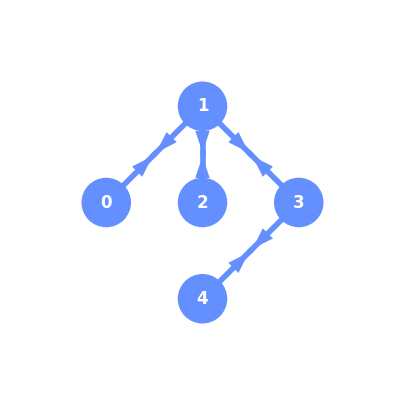

In [31]:
from qiskit.visualization import plot_gate_map
plot_gate_map(backend, plot_directed=True)

In [78]:
token = 'f6d369be71e5296d4290c379588aa8b5da8b2d4a413b76973b4f35345177d0a99a56e80c81623967f47049998bf7eb37331e5ff7dd8fda8ad62e56745a01c420'
hub = "ibm-q"
group = "open"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAZQAAAGVCAYAAADZmQcFAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAmlklEQVR4nO3daZAcZ53n8V9WX7pallrWZZ2WdVjCSPIhywJjS7YDG9/gBTwcXgY8xMIuMcROxOxM7M4Su8S+2I1hFpZl2dnFMINhwgwY8H0ssuULWZYPSRaSdV+ts63Dal19Ve6Lv5I+1NVV1f1kZeZT309Eh1rVVVlPVWXWL58nnyMIwzAUAABDlEu6AAAAPxAoAAAnCBQAgBMECgDACQIFAOAEgQIAcIJAAQA4QaAAAJwgUAAAThAoAAAnCBQAgBMECgDACQIFAOAEgQIAcIJAAQA4QaAAAJwgUAAAThAoAAAnCBQAgBMECgDACQIFAOAEgQIAcIJAAQA4QaAAAJwgUAAAThAoAAAnCBQAgBMECgDACQIFAOAEgQIAcIJAAQA4QaAAAJwgUAAAThAoAAAnCBQAgBMECgDACQIFAOAEgQIAcIJAAQA4QaAAAJwgUAAAThAoAAAnCBQAgBMECgDACQIFAOAEgQIAcIJAAQA4QaAAAJwgUAAAThAoAAAnCBQAgBMECgDACQIFAOAEgQIAcIJAAQA4QaAAAJwgUAAAThAoAAAnCBQAgBMECgDACQIFAOAEgQIAcIJAAQA4QaAAAJwgUAAAThAoAAAnCBQAgBMECgDACQIFAOAEgQIAcIJAAQA4QaAAAJwgUAAAThAoAAAnCBQAgBMECgDACQIFAOAEgQIAcIJAAQA4QaAAAJyoTboAQNqEoXSsVdp9WDraKnV0Sl1dUk2NVFcrXTxamjFBamqUgiDp0gLpQaAAkg4ek9a8J+08aEFytt1uD4LzP5JCWdiEof1teL00c6I0a7K09HJpclNSpQfSIQjD6PAAqktnl7R+p/TCOmnrfikXSPlBHA3R4+ZOkW5aLC2aJdXWuC4tkH4ECqpOPpRe3iA9/rrUenbwQdJXtJ3G4dLd10k3LLTbgGpBoKCqtHwg/eR5adv++J9r7hTpSx+Xxl8U/3MBaUCgoCrkQ+mlDdIvX5a68m5qJMXkAqkmJ336BulGaiuoAgQKvNfZJf3oWemtbcmV4eo50oO3cW0FfiNQ4LX2TukHj0ub91ovraQEkhbMkL5+l1RP30p4ioGN8FZnl/TDJ6TN+5INE8mef9Ne6YdPWrkAHxEo8NZPfyf9YU/3uJGkhaH0h91WLsBHBAq89OZWafXm5GsmfYWycr25NemSAO4RKPDOyTPSwyuTLsXAHl4ptZ5JuhSAWwQKvPPzF6Rz7UmXYmDn2qWfvZB0KQC3CBR4Zd0O6e3tlRlnMhT50Mq5bkfSJQHcIVDglWfWZmcG4CCw8gK+IFDgjX0t0s5D6enVVUwYWnmbW5IuCeAGgQJvrNqQvelNcoGVG/ABY3bhhTNt0upNbq+djGiQbr1GumyyrXvSUGe3/36TTTDpQj607d13vTS8wc02gaRQQ4EXNu+VOhyPQB83Wrp9iTRvaneYxKGjy0bzA1lHoMALe45IOcd7c2eXtKVZenqt9OpGt9vuKZeT9hyOb/tApRAo8MLuQ1I+73abB49Jf/sr6Tev2bLAccnn490+UCkECjIvDLP/hbzrcHZ6pwGFECjIvGOt0tmUj4wv5mybvQ4gywgUZF7r2aRL4MYpT14HqheBgszr6Ey6BG647qUGVBqBgsxzfTE+KV2evA5ULwIFmVfryfDcOtabR8Z5ciiimjXEtBfX10pXzLTfp03ovr2pUbpqtv2++7C7i+msNY+sYxdG5o0fIwVyvzpj4wjpa3deePvl0+xHsilYfr9p6M8VBNKEsUPfDpAkmryQeQ110sSMfxlPHEMNBdnHLgwvzJosHfnA7QX6oyelP/uuu+0VkgtsAkog66ihwAszJkhhRntJhaE0Y2LSpQCGjkCBF2Zf4v4aSqWEooYCPxAo8MK08dLUi+3ifJYEsnJPG590SYChI1DghSCQblqcvVpKKOnmK638QNYRKPDGtfPiXQgrDsPqpCVzky4F4AaBAm801EkfuyI768rnAun6K7IXgkAhBAq88okl0rD6pEtRmmH1tsQw4AsCBV4ZPUL64s1Jl6I0D9xio/EBXxAo8M41c22urbQ2feUCK9/Vc5IuCeAWgQIv3b88vT2ngsDKB/iGQIF3OrukX7yU3vVFuvJWvk4W1IJnCBR4pbNL+tGz0lvbki7JwN7aZuUkVOATAgXeyEqYRAgV+IZAgReKhUldjdQ4vPLXVYLAnrfQaoyECnzC9PXIvGJh0lAn/fm9Nl/Wo69KqzbYF30Y4zwt0fZv/LB03/XSvhbpe7+V2jouvG9U7gdvk2pZBhgZFoRhnIcVEK9Sw2TOlO7b3tsn/fg56fip+MrVNEr601u7V3aUpG37C4eKZN2ICRVkGYGCzBpMmETaOqTVm6WV70iHjtvYkPwQjoTo8ZObbJLKZfP7n1KFUIHPCBRk0lDCpKcwlLYfkF5cb9vKhzalfFAkYHLnm7TC879fPUdascjWZSl2nYZQga8IFGSOqzDpq7lF2n1YOnhcOnRM2v++dKz1winxa3PSghnSpCZp8lhp5kRpapnrmRAq8BGBgkyJK0wk6ck10mOry3/cPcukO5eW/zhCBb6h2zBS6eGV0tGTvW+LM0wk6ZpBzq012MfNmWLlLTR9faEuxUdPSj9bObjnBOJEoCB1th+QXn5X+s6j3aESd5hI1oQ15eLyHjP1YnvcYJUbKkdP2vvy0rv2PgFpQqAgdZ543f5t+cC+PI+ciD9MIuXWNlzMGFxqqBw5Ye9Hywd2e/Q+AWnBNRSkyvYD0n/959631ddJ7QWuM7gME8kuxv/NT0u//7cfGFoNpadi11T6ex/+3WesZxmQBtRQkCr9nXVXKkyk8pq9htrc1Vexmkp/7wO1FKQJgYLU2H5A2rS3tPvGESaRUpu94lggq1io9LVpL9dSkB4EClKj1LPt+tr4wkQqPVAG27urmChU6kucaY9aCtKCQEEqlFM7GdEgNTXGV5ZSmr1cN3f11dRor7MU1FKQFgQKUqGcs+wTp3t3KY5DsdpHnOvBR12DT5wu/THUUpAGBAoSV07tJBJ1KY4rVIoFSlzNXVGYRF2DS0UtBWlAoCBxjw9iuhNJqsnZTMFxGKjZq742vuaug8fsdQ3G49RSkDAW2EKituyTNu8r7zGTxtrcWUvmSrkYT4mumWMTRPY1clh8z3nFTGnBdGntVptbrJzA3LxX2tIszZsaW/GAAVFDQWI6u6S/f6b0+08aa5Ml/qcvSksvjzdMpMLNWnEGimSva+nl9jofvM1ed6n+z9MsJ4zkUENBIjq7pO/+Rmo9U/y+laqRXPC8Tda81d7Z+/ZSu/MOVRQsS+aWXmM5ecbe129+klmKUXkECioumuhxS/PA90sqSHoaOUxqj3Gp4FKUGyxbmu39Zep7VBqBgooqNmuwZGMwPvXRZIMkMnJYvGvPl6NvsPz6NVsArD/R+0uooJIIFFRMsTAJJN2xVLprafJBEqlU81Y5egbLE2ukp9ZcuKqkRKig8lJ4uMBHxcKktsba/emhVLpczlaLvHyaXTfp72I8oYJKSsl5IHzW1m6D9QqFSX2t9G8/RZgM1ryp9v4Vqk29tc3e/7b2ypYL1YdAQaza2m19kUKjuBvqrGYS10SPQ9XfiPVyR7FXwpwp9j4WmqV4+wH7HAgVxIlAQWyiMCl0UTvOKehd6dtluNBtaVBs6vvjpwgVxItAQSx8CJMsIlSQJAIFznV2Sd/97cDdbR+8jTCJy5wp9v4WcvyUfT6MqIdrBAqcinpzDTTz7edWSIsvq1yZqtHiy+x9LmT7AfucCBW4RKDAmVIGLX5uhbRiUeXKNFT99ZxK49iU/qxYNHCovLWNUIFbBAqc8DFMJGn8RaXdllaECiopI+daSLNiYdJQJ33lNulKmrkSsWKRNGaU9NCzUlvHhX9n8CNcoYaCIYlmDR4oTP78XsIkaVdeNnDvr7e2FR5tD5SKQMGgbdkn/eVDhWcN9qFrcNjfJFkZVaxL8ZbmgT9PoBiavFC27Qds2d6BVlqsr81+mEj9NxFlWRQq3/1N/wM0W89If/sraf406e5l0uxLKl5EZBiBgpJtPyA98bq0ae/A94smesx6mEjSqXNJl8C9aJqWv/t14SauzeeXZl4wXbrrOoIFpSFQUFSpQSLZFPS+hEk+lE73Eyg+NINFofKdX/U/9X1k0177IVhQCgIFBZUTJJE7lvoza/COA1JX/sLbfWkGmzfVPq8n1xS/L8GCUhAouMBggkSylRbvWhpPmZLwZoGeaz41g921VPr9psIrP/ZFsGAgBAp6eXil9PK7g3vspz6anpUWhyofSm8XCJTT5+zvuaCyZYpDLmef24+eLe9xUbDc8GHpizfHUzZkjyeHP1y5fcngRoJPGmtL0vpixwHpxOn+/9aVt7/7Yslc+/zKNf4i21+ACIGCXsaNlv7ivvJD5c4UrQPvQqHmrshAU8xkTS5nn185xl9k+8m40fGUCdnk0VcAXBk32noA1RcYANeXb7WTgZq7Im9ts/v5opxaSv35VTYJE/RFoOACnV3Sr1+T2kvszeRb7WSg5q7IidN+NXuVU0tp77D9g2la0JdHXwNwoZRZg3vyrXYiFW/uivjU7CWVV0thlmL0h0DBH5UbJpJ/tZNSmrsivjV7lXsthVBBXx59FWAoioVJfa00ZmTv23ysnZTS3BXxrdlL6r+WMmZk4UXFCBX0RKCgpPVMvvlJ6a8+27v3l2+1E6n05q6Ib81efWsp4y+yz/2bnxx46ntCBRKBUvVKCZNo1uCeXYp9rJ2U09wV8a3ZS+qupfTsGlxs6ntCBZIUhKEPU91hMMoJk56OnpQOHZc+NCP2IlbUtv3Sf/tl+Y/7y0/7MRlmTxt3S5ObLuwavG2/9L3fFp7P7Oo5rPxYzQiUlApDm1+p9azU0Snl81JtrdRQK40fU/hMsVSDDROf/eoV6cX13f8PQ6mjwBl3z2sKKxZJ/+Jj8ZYtTSoVKm0dUssJqa1T6uy05ri6WqlxuM0bF3gw9Y1vCJSUONMmbd4r7Tki7T4k7T4snW3v/75BIE0cI82aLM2YYBP0TRtf+gFGmFyoKy9tbZZ2HbLPYOch6cSpwvcfM0qaNcne/0snSXOnSjVV1IDsOlTCUNrXYhOT7jki7TwoHT5ReKmA4fXSzInSzPOfwfzp0oiGwbwSuESgJGxfi7Rqg7R6k50N53JWGylFLieFeVvPYurF0k2LpWvnDVx7IUx6O3FaeuVd+wxOnrEJH0OVtuZJENj6L/lQGj3CairXX3FhbzhfuQiVtg7pjS3SC+uk5vft/QzKPAbyeamuRlq2QFqxUJo6vswXAmcIlISs2yE9s9bOhHPB0C/sBrIvwoY66WNX2KR9jSN634cw6bavRXrqDemd7aUHSDFRwFw5W7rjWqs1+m6woXLyjO3/r2y0x0b771BEx9GsSdInlkiLLxviBlE2AqXCTp6Rfv6C9PZ2+wKK493PBdKweptW/JrzPbEIE9PZJT39hoWJFE8PrWha+zuWWrD7foG63FB5c6stk3CuPZ73PzqurpotfeGmC0+sEB8CpYLiPpD6c9Vs6f7l0i9eIkz2HpEeek46cLRyz3nJOOkrt0rTJ1TuOZNQSqh85gbbD9/eXpky9XdihXgRKBXQ2SX94/+TXn+v8s+dC+yMrb+lbKXqCZMX10uPrLLfKzluJKqt3L/crrH4rFio1OSs5pDEuJ1l86UHbvG/tpg0AiVm7Z3SD5+Q/rBn6G3ErlVDmIShNW89tjrpkkj3LLNrKz53dy0WKkkJJH1opvS1OwtPI4Ohq6KOjpXX2SX94HHpD3sJk6SkJUwkK8fTa5MuRbyKjahPSig7qftfTzCaP04ESkzyoV0E37w3ngvvQ1FXUx1h8uL69IRJ5Le/7z140kdRqNSlrHkpDKVNe+y49G26nLQgUGLy0ga7CJ7G/XZYvf9dWvce6b5mkjaPrLLy+WzaeNvP0iaUHZcvbUi6JH4iUGLQ8oH0y5eTLkVhp85Jj76adCni09llvbnS7KHn/G56efRV28/S6pcv23EKtwgUx/Kh9JPnC/eqSoMwtJHh7+1LuiTxePoN6xqc1maNfGjl8/V6yuZ9tn+lram3p6689A/Pp3cfySoCxbGXN1hPl7TvqEEg/fi59PXGGapoBHwWPLXGyuuTtg7pJ8+lvydbPpS27rfjFe4QKA51dkmPv550KUoThtLxU9LqzUmXxK2shEnk6YyVt5jVm2y/SnPtpKfHX/e76bHSCBSH1u+06eazIpBNypeVg7+YE6dtbq601w4j+dBGjX9Q4pLDaReG0sp1SZeiPK1npQ27ki6FPwgUh15Y1z0yOgtCSQeP2ZThPnh1Yzp71Q0klE2Q6INtB2zhtSzJBXbcwg0CxZGDx6xNNitnx5Fc4Me4iK68vY6s1bbC0Mqd5k4cpVq1PlsnVJIdr1ua7fjF0DEJgSNr3nMzDX1PtTXSx6+Sll5u63u3ddhZ4JOvS3sdXczNh9Yvv70z21NSbG22mZxdmTbe1lafM8WWwW0cLp1ts+UGnnvTPgdXTp6x8s+f7m6bldbWYfuRq/1/yjjptmukGROli0bavnm2XWpukV79g62h4kousOP33o+422a1yvBXSLrsPOg2THKB9I17pAU9vmTqaqUrL5OumCH9j8fcdfvNn18t77LJbraXhF2O1pWJ3Phh6caFvW9rHCEtmiV9eKb0v5+S3tnh5rlyga3QmeVAaW5xu/9PHS9dN7/3bY3D7T2aP91C/hlH3a7zoe0/GDoCxYEwtC8El5Yv6g6T5velx1fbFOh3LrVg+dOPS//+H9z0UAlkI7ezHCh7jri/fnLitPTaRquNjBxm7/3kJlsl8DM3uguUUO73n0rbc8TNIlmR0+ekl9+1ZuQPTtv7f8uVtty1ZKuTugoUSdp12I7jtHd3TjsCxYFjrYXXfx+sGz/c/fvDv7Omlnd22DraV8yUmhqlhZe6WVsiCKQ9Gf9C23nI7fWT19+T/vllawqMHDgqfesL9vvF55vBXPTqCz04Q95zxJbuDR1dC9q42356OnJC+o+ft9+HOZ588mybHcfjRrvdbrXhorwDrs8uRzTYwkyS1UB29dj+joPdv7ua3DEf9t5u1pw6K5045Xab2w/0DhPJvtB66vv3oTh+yl5HVu08WPo68OUKZNdRbuhxkrWl2f3z7PF8frVKoIbiwNFWt8v5XtzjLOnUud7bbT3T//2G6liru21V2tEKlf2q2d2/b212P8vAsVZp1HC326yUuPafv/6sNKtHU2w+lN7dZQvWuRQE0tGTbrdZjaihONDR6bbttedaEl19rpH0vGZS77Dan+Vuqx0OawqFTJ8g/cmK7uf7RQyTf1bidcSlUqPNw9BqQq6vdQTK9vufFtRQHOjqsh3SlZ5nvn2XLO35/3aHZ8hd+exelOwbuq7NvsR63I1osC/O//tMPNPPZ3UKkDiX9f3pSmlkgzS2UVq+0D6LK2dLY0dJ/+URd88TBNl9/9OEQHGgpsZtD6P3e1S9Rw7r3R129Mj+7zdUNblsholk739cFkyXvn6X1Ro7OqW/f9qm2IlDVtc7DwL3Y7Ai+9/v/v2d7dJ//1c2JmXmJGniGOnwCTfPE4bZff/ThCYvB+pq3fYwOtNmPYok28lnTur+W8+uvdv2u3vOmgzvCXUxnRZdeZn0b+62MDnXbmN/4goTKb7XUQmuv4wLrfbY8zgb3uDu+UJl+/1PC95CB8Y1up/y46V3pT9Zbr8/cLMtZTtjgvShGXbbsVa3k9o1NbrbVqWNi6HsV8+R/uwTFrT5UHpijTWJROMgJOvd57KZJMufQVOj23m8/sPnrOfYtgO2r48eYU1e0fXFtg6306WEIV2GXSBQHJg50f02V623UdkLpktTLrZml0hHpy3i5erLLBdke1DjqOHSmFFuuw4vvLS71pYLpE9/7ML7/NWP3fUMGjsquz28JOuJdeQDd12H6+uk66+wn/786hX3vexmTHC7vWpEoDjQ1CgNr3c7uDEfSt9/zObyum6+dRFu67DxEU84nMtLsrOzGTGEYiXNmmQDP7M2OaRk1yAunVT8fmk2Y4KtheLK82/ZCdXkJhtAKtmI+R0HbT14l3OpSdZ8luUaYloQKA4EgdVSNjteUrezy5aJjXup2FDWLTbLZkyQ1u1w1zniJ8/bTyUEiqeWW0kzJrjtmPLi+srOgn3pxOx2SkmTDF+KTZdZk7M3dXckF9jsull26aTsLR0QyYfZD5Sp47O9/2e9hpgWBIojSy/P5hdaLrAL0Fmeul6S5k61C7dZNHqElT/LGupsP8piqORD6brLky6FHwgURyY3SXOnZO+AyofSikVJl2LoanL2OrLWbBEEVu4sd9uOLF+UvZOqXCDNmypNakq6JH7wYDdOj5sWZ+uACmRB2LMrbJZdf4XbGQsqIZD0sQI9mbJmziXSpLFJl6I8+dCOW7hBoDi0aFZ3j5QsCGUHU9bO6gsZM9Km5chKLTEX2ISTF40sft8sCALp5sVJl6I8jcPtuIUbBIpDtTXS3dclXYrSBIGNfVg2v/h9s+SOa5MuQXluz1h5i1m2wParrJyk3H2dH82NacFb6dgNC22dkrSfJYeh9JVbe89s7INp47MTKncszX7vur4a6qQv35r+8UC5wK553rCw+H1ROgLFsVxgy/Om+awnCGwai3nTki5JPG6/1hYoS2uo5wJpyjjp9iVJlyQel0+z/SvNtZSanPSlj6d3H8mqFH/tZdf4i6RP35B0KfoXBHat4b7rky5JfGprrPaVZl++1e/Zbe+7Xho1LOlSFPbpG+w4hVsESkxuXGj98tN0AhRIqs1JX7tTGlafdGniNX2CdP/ypEvRv/uXZ39mgmL2tdgMzWkTyI7LG2nqigWBEpNcID14mzR/ejqq/oGkIGcLRVXLqOAVi6R7liVdit7u/Ygf434Gsm2/9L3fSh0pW7AqCKQFM+y4pKkrHgRKjGprpH99t005n+T+GwS2CNU37raAqyZ3XGtf4mlw70f8vW4SicLE9UzAQxXIjsOv3+V3U2PSgjBMe3+M7Ovskn76O2n15so/dy6w5q1v3OPPAMbBeHG99Mgq+72Sg0+jM+H7l1dPzaRQmNTk4l0ueCDL5ksP3EKYxI1AqaA3t0oPr7S25UodVFfPkT6/QmrM6DxXLu09Ij30XPdqmJUwZZz0ldv86x7cV7EwuXqO9NkbLdTf3l6ZMkUnUw/cYs+P+BEoFdZ6RvrZC3ZQBUE8/fU5kAqLlgR4ao39P45gj2oldyy1Ji7fz4pLCZMHb+t+H+I+sYqOK06mKo9ASci6HdIza6Wdh+wLaKgHViCbSmXY+ZXubl/CgTSQfS3S029YsIdyE+xBYJ/DVbNtLIzvtRKp/DCJtJ6xYH91o3Suo3v/HYroOJo1SfrEEmnxZUPcIMpGoCSsuUVatUH6/SbrFZPLlb6Mau78mVgoaerF0s1XSkvm+jf6PU4nTtuX2ovrpZNnzr+nKi1gogDJhzYF/YpFNtGjL3NzFTPYMOmprUNau1Va+Y7U/P753ohlnGBFx0tdjfSRBTagcmoVBHlaESgpcbbNVnzcc1jafVjaddhu608QSBPH2DrwMybav9PGp6N7clZ15aWtzfbe7z5sNceB1qgfO8q6X8+caD9zp6Z7dgTXXIRJT2FotcYdB8+//welwycKB/vwBltlceZEOwbmT7PbkCwCJaXCUDrWKp06azWXrvNnYfW10oSx2V8QKwtOnbXPoKPTrr3U1kh1tbb2+KgMzSrtmuswKaS9Uzpy3P7t6LLArqux976pkROoNCJQAFxg425bK2fc6N63VypMkE1VVEkHUIp8XvrFS9J3HpWOnuy+nTBBMQQKgF7WbpUOHZdaPugOFcIEpaDJC8Af5fPStx62QImMGSmdabNrGf0hTBDh0i6AP4pqJz2dOF34/oQJeqLJC4Akq508uab0+xMm6ItAASCp/9pJIYQJ+kOgACirdlJfJ33qo4QJLkSgACirdtLeIX33N727FAMSgQJUvXKvnUi9uxQDEQIFqHLl1E56avnAZswGInQbBqpYPi/9+rXyH7dgunTXddW9CiguRKAAVeyJNTYBZqkIEgyEQAGq1Jbm7pUriyFIUAoCBahC2/ZbT61i8y4RJCgHgQJUmShMOrsK32f+dOluggRlIlCAKhLNGlxoosfRI6Sv3i7Nm1rRYsETBApQJYpNQT9vqvTNTzICHoNHoABVYN0O6UfPsp4J4kWgAJ57cb30Ty8W/jthAlcYKQ94jDBBJREogKcIE1QagQJ46J0dA4fJ7EsIE7hHoACe2bZfeujZwn8fO0r65r2ECdwjUACPFOsaPHaU9O0HpIb6ihYLVYJAATxBmCBpdBsGPBBNp1JoBPzsS6yZizBBnAgUIOO2NA88Nxe9uVApBAqQUfm8rWfy1JrCswYTJqgkAgXImHzelu399WsDL45FmKDSCBQgI6IgeXJN8TXgCRMkgUABUq6cIJFs1mDCBEkgUICUKjdIJFvPhCnokRQCBUiZwQRJ5Ku3EyZIDoECpMjG3dIvXio/SCRbtpeVFpEkRsoDKTK5SerKD+6xd1/ntixAuQgUIEXGjZb+4j5p/EXlPW7BdBsNDySJQAFSJgqVMSNLf8xd1E6QAgQKkELHWqUzbaXdl9oJ0oJAAVImmjW40ESPfVE7QVoQKECKFJuCvi9qJ0gTAgVIiWJhUl934W3UTpAmBAqQAsXC5Oo50rc+37v3F7UTpA2BAiSslDB58DZpwpjeXYqpnSBtgjAMCy2lACBmpYZJz+lUjp6UnlkrfeHmihQRKBmBApQgDKUgcLvNwYQJkGbM5QWc19YhNbdIe47Yz86DNh6ks0vKh1IusC/3pkZp1mRpxgT7mTpeaujngvlACBP4iBoKqloYStsOSKvWS29ts+AIJAU5m/W3kFxOCvO29G4usABYvkiac0nxmgxhAl8RKKhKbR3S6k3SynU2s28usDAZrOjxk8ZKNy+Wli3ov9ZCmMBnBAqqznv7pB8/Jx0/Fd9zjB0lfflW6fJp3bcRJvAdgYKqca5devRVadUGa5aKc8+Ptr98oXTf9dK+FsIE/iNQUBV2HZJ++KR04nS8QdJXEEijhlmYdXT1fx/CBL4gUOC9TXul//mY1JmvbJiUgjCBT+g2DK9t3C19//HuHllpQpjAN0y9Am9tPyD94AnCBKgUAgVeOnlG+v5jtj572sKkJid99kbCBP4hUOCln79gF8LTds1EsjI9sirpUgDuESjwzptbpbe3D22gYpzyoZXvza1JlwRwi0CBV06ekR5emXQpSvPwSqn1TNKlANwhUOCVZ9ZaU1cWnGuXnl6bdCkAdwgUeKOtQ3plY3qbuvrKh9KrG0tfPx5IOwIF3nhjS/a+nM91SGu5lgJPECjwQhjazMGO18CKXSBp5Tvp7I0GlIuR8vDCvhZp//vxbf8b90gLL+3+/9/8o017P1ShpOb3rfzTJwx9e0CSqKHAC9sPxFc7WTqvd5i4FkjacTC+7QOVQqDAC3uO2CqLro0aZqPa86HU0el++5LNSLzncDzbBiqJQIEXdh4ceMnewfrsjVLjCOs99kFMY0byITUU+IFAQea1dUiHHVzP6OtDM6Tr5tvKjo++4n77PR0+IbXHVAMCKoVAQea1nHA/AWRDnfSFm+33n78gnY15sGQYSkdiCEWgkggUZF5bDGf2935Euni0zbe1fqf77feHGgqyjkBB5nU6/iKeNFa6aZF0+pz0T6vcbnsghZYIBrKCcSjIvJzj06LRI22bI4dJf/fV/u/z7X9pY0f+88/dPW8Np3fIOHZhZF6dJ6dFdSy4hYzz5FBENWsc7nZ7LSekR1668Pa7llqtRZKefkM6cNTt845y/DqASiNQkHlNjdLwenc9sY6fsvm1+rrlyu5AWb3ZzdQrkeEN9jqALKPJC5kXBNLMiUmXYmgunWivA8gyaijwwsxJ0pb98YyWj/z1j+PZbi6X/UAEJGoo8MSMCfGGSZzyeWkGgQIPECjwwvzp2e0lVVcjzZ+WdCmAoSNQ4IURDdKyBVIuY9chcoH0kQV2UR7IOgIF3li+MDvryUfyoZUb8AGBAm9MGy/NmpSd3lJBYOWdOj7pkgBuECjwyieWZGd99jC08gK+IFDglcWXSVfNTv+1lFxg5Vx8WdIlAdwhUOCdz98kDatPuhQDG1YvfeGmpEsBuEWgwDujR0hfvDnpUgzsgVtsaWHAJwQKvHTNXGnZfCltLV+BrFxXz0m6JIB7BAq89cAtti58Wnp9BYH0oZlWLsBHBAq8VVsjfe0uacH05GsqgawcX7vTygX4KAjDrHSyBAans0v60bPSW9uSK8M1c6Sv3EaYwG8ECqpCPpRe2iD98mWpK1+ZEfW5wJb1/cwN0g0L09+VGRgqAgVVpeUD6SfPS9v2x/9cc6dIX/q4NP6i+J8LSAMCBVUnH0ovb5Aef11qPWs1Bxc1lmg7jcOlu6+jVoLqQ6CganV2SRt2SS+sk7Y0Dz5YosfNmyrdtFhaeCnXSlCdCBRA0sFj0pr3pF2HpF2HpbNtdnsQWA+tILC5t0J1zxU2vMGW7r10krT0cmlyU1KlB9KBQAH6CEPpWKu054h09KTU0Wm1mdoaqa5WGjfaVohsakzPGBcgDQgUAIATDGwEADhBoAAAnCBQAABOECgAACcIFACAEwQKAMAJAgUA4ASBAgBwgkABADhBoAAAnCBQAABOECgAACcIFACAEwQKAMAJAgUA4ASBAgBwgkABADhBoAAAnCBQAABOECgAACcIFACAEwQKAMAJAgUA4ASBAgBwgkABADhBoAAAnCBQAABOECgAACcIFACAEwQKAMAJAgUA4ASBAgBwgkABADhBoAAAnCBQAABOECgAACcIFACAEwQKAMAJAgUA4ASBAgBwgkABADhBoAAAnCBQAABOECgAACcIFACAEwQKAMAJAgUA4ASBAgBwgkABADhBoAAAnCBQAABOECgAACcIFACAEwQKAMAJAgUA4ASBAgBwgkABADhBoAAAnCBQAABOECgAACcIFACAEwQKAMAJAgUA4ASBAgBwgkABADhBoAAAnCBQAABOECgAACcIFACAEwQKAMAJAgUA4ASBAgBwgkABADhBoAAAnCBQAABOECgAACcIFACAEwQKAMAJAgUA4ASBAgBw4v8DROeU82g/oI0AAAAASUVORK5CYII=
project = "main"
credentials = {'token': token, 'hub': hub, 'group': group, 'project': project}

In [83]:
qasm_string = transpile(tri_circ, backend=backend).qasm()
print(qasm_string)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c13[1];
rz(-pi) q[0];
sx q[0];
rz(2.681213181196415) q[0];
sx q[0];
rz(-pi) q[1];
sx q[1];
rz(2.1011825681744245) q[1];
sx q[1];
cx q[0],q[1];
rz(-pi) q[1];
sx q[1];
rz(2.898289878244224) q[1];
sx q[1];
cx q[0],q[1];
rz(-pi) q[2];
sx q[2];
rz(1.5128665332200883) q[2];
sx q[2];
cx q[1],q[2];
rz(-pi) q[2];
sx q[2];
rz(2.6374639028242717) q[2];
sx q[2];
cx q[2],q[1];
cx q[1],q[2];
cx q[2],q[1];
cx q[0],q[1];
rz(-pi) q[1];
sx q[1];
rz(2.6047594573722392) q[1];
sx q[1];
cx q[2],q[1];
rz(-pi) q[1];
sx q[1];
rz(2.66968806735278) q[1];
sx q[1];
cx q[0],q[1];
rz(-pi) q[3];
sx q[3];
rz(5*pi/7) q[3];
sx q[3];
cx q[1],q[3];
sx q[3];
rz(5*pi/7) q[3];
sx q[3];
rz(-pi) q[3];
cx q[1],q[3];
cx q[3],q[1];
cx q[1],q[3];
cx q[3],q[1];
rz(-pi) q[1];
sx q[1];
rz(3*pi/7) q[1];
sx q[1];
cx q[2],q[1];
sx q[1];
rz(3*pi/7) q[1];
sx q[1];
rz(-pi) q[1];
cx q[2],q[1];
sx q[1];
rz(pi/7) q[1];
sx q[1];
rz(-pi) q[1];
cx q[0],q[1];
rz(-pi) q[1];
sx q[1];
rz(pi/7) q[1]

In [80]:
supported_devices = fireopal.show_supported_devices(credentials=credentials)[
    "supported_devices"
]
for name in supported_devices:
    print(name)


Authentication URL:

https://id.q-ctrl.com/auth/realms/q-ctrl/protocol/openid-connect/auth?response_type=code&client_id=cli-python&redirect_uri=http%3A%2F%2Flocalhost%3A8000&scope=openid+profile+email+offline_access&state=GqXjjWUolHql8QmZS4kXh9CVjmCIZO

The URL above should be automatically opened in your default web browser.
(Please copy and paste in case it doesn't open automatically)

Authenticate your credentials in your browser...

Finalizing authentication...
Successful authentication!
ibm_nairobi
ibmq_belem
ibmq_jakarta
ibm_lagos
ibm_perth
ibmq_lima
ibmq_manila
ibmq_quito


In [84]:
circuit_errors = fireopal.validate(
    circuits=[qasm_string], credentials=credentials, backend_name=backend_name
)

In [85]:
# Could run this but currently on real qubit devices the waiting time is 2 days. 
shot_count = 1024

fire_opal_results = fireopal.execute(
    circuits=[qasm_string],
    shot_count=shot_count,
    credentials=credentials,
    backend_name=backend_name)


KeyboardInterrupt



## 5. Benchmarking
* Do you estimate this use case will benefit from NISQ devices or do we need Fault Tolerant Quantum computers?
* What metric would be more appropiate to compare the performance of your Quantum Monte Carlo solver vs the current classical methods?
* <font color=red> (Optional. Advanced) Assume you are a quant at a financial firm. You need to apply Monte Carlo simulation to price (i.e. the expectation of the total assets value) of a portfolio of fixed-income assets (e.g. 10k assets). An accuracy of the order of epsilon = 10e-6 is needed. Notice that the underlying uncertainty of fixed-income assets stems from interest rate and they do not have to follow a GBM like model. For simplicity, take into account that interest rates are only modeled up to one period (T=1), resulting on one-dimensional distribution. There are other models typically used to model the paths of interest rates. Make a rough but reasonable estimation of the quantum hardware resources needed to implement quantum Monte Carlo simulation for this set up. </font>


Cite your references.

A1: Yes, Fourier QMCI will benefit from NISQ devices for several reasons [Ref 1].

1. **It does not rely on quantum phase estimation (QPE).** QPE requires fault-tolerant quantum computing due to its need for a large number of qubits and quantum gates for high precision, as well as high-fidelity basic operations to avoid the fast accumulation of errors from multiple control-unitaries.

2. **It simplifies the arithmetic on the quantum side compared to previous QMCI approaches.** By considering the function $f(x)$ on the finite support of $p(x)$ and defining a corresponding periodic function $\texttt{f(x)}$, the Fourier series of the new periodic function $\texttt{f(x)}$ can be computed classically. This not only avoids complex quantum arithmetic but also achieves better accuracy than linear approximation methods [Ref 2, Ref 3]. The quantum arithmetric is shifted to classical side, where better precision can be achieved. Moreover, the classical arithmetic complexity does not depend on the number of sample, but only on the step used in the integration.

3. **Fourier QMCI will be valuable during the transitional period from NISQ to Full-Scale Fault-Tolerant (FSFT) quantum computing.** The transition from NISQ to FSFT will not be sharp. As qubit numbers increase, it becomes reasonable to consider quantum algorithms with low-depth circuits, such as Quantum Amplitude Estimation for trigonometric functions used in Fourier QMCI, provided they can adequately manage noise. Eliminating the need for depth-consuming arithmetic operations is a crucial step in this direction.

4. **Fourier QMCI might still be useful beyond the NISQ era,** It depends on how well the circuit level noise is mitigated in the FT era. The elementary gate sets will tend to have better fidelity (noise needs to be well below the threshold to get to a $10^{-10}$ logical error rate with $~1000$ data qubits), the Fourier QMCI executed on these device can also benefit from these improvement. When using all the ancilla for error correction to the MC computation, we have a much larger computing platform than the logical-qubit platform.

A2: One metric to compare is the **mean square error (MSE) given $N$ samples**. Classical Monte Carlo integration has MSE of $\Theta (N^{-1})$, Fourier QMCI is $\Theta (N^{-2})$ [Ref 1, Ref 4]. This advantage in query complexity was shown. However, other factors need to be taken into account as well in order to evaluate whether we can benefit from QMCI. 
<!-- - The overhead of the query complexity.  -->
- The complexity per query, although the Fourier QMCI has less query complexity, per query it might be more difficult than the classical MC, because the state perparation of $p(x)$ could be hard. There may be errors induced by the gate sets
- Classical post-processing of the quantum algorithm. The quantum MCI shifts the complicated arithmetic to the classical side, which involves the calculations of Fourier coefficient. This may not be an easy task for non-ideal functions (In [Ref 1], $f(x)$ is assumed to be "continuous in value and first derivative, and has second and third derivatives that are piecewise-continuous and bounded."), where more Fourier coefficients have to be involved in the series approximation.
<!-- [Ref 1] claims a cubic decay ($n^{-3}$) of the Fourier coefficients. However, for a general $f(x)$, the coefficients only decays linearly ($n^{-1}$). And to calculate each coefficient, the numerical integral with $m$ points in the interval will have a complexity of $O(m\log(m))$, using the Clenshaw-Curtis method [Ref 5]. -->

[Ref 1] Herbert, S. (2022). Quantum Monte Carlo integration: the full advantage in minimal circuit depth. Quantum, 6, 823.  
[Ref 2] Woerner, S., & Egger, D. J. (2019). Quantum risk analysis. npj Quantum Information, 5(1), 15.  
[Ref 3] Stamatopoulos, N., Egger, D. J., Sun, Y., Zoufal, C., Iten, R., Shen, N., & Woerner, S. (2020). Option pricing using quantum computers. Quantum, 4, 291.  
[Ref 4] Intallura, P., Korpas, G., Chakraborty, S., Kungurtsev, V., & Marecek, J. (2023). A Survey of Quantum Alternatives to Randomized Algorithms: Monte Carlo Integration and Beyond. arXiv preprint arXiv:2303.04945.
[Ref 5] Clenshaw, C. W., & Curtis, A. R. (1960). A method for numerical integration on an automatic computer. Numerische Mathematik, 2, 197-205.
    

## 6. Pitch your quantum strategy to a client: a bank
Imagine you are part of the Quantum team at Moody's. You are meeting the CIO of an important bank in the US, and you need to convince him/her in 5 minutes about why they should start investing in quantum computing today, and define the steps of a high level roadmap they would need to follow to get quantum ready. You can use the Quantum Monte Carlo use case as a proof of concept to support your pitch. 

You may use up to 3 slides, including roadmap, PoC results and executive summary on why to invest in quantum today.


<div class="alert alert-block alert-warning">
<b>Hints:</b> 
    
- Research what is an executive summary, and an elevator pitch, and try to follow some of the ideas of these communication tools.
- Think about the person you are presenting to. Are they technical people? What is important to them? Build a empathy map to help you build the right message.

</div>

<img src="files/empathymap.png"  width="200">

In [5]:
# Build your presentation and rehearse your pitch!

# This is the end of the challenge. Good luck...

<img src="files/keepcalm.png"  width="200">